# Extract all images from a TraP dataset with extracted sources as overlay

When executed it will try to download all images from the dataset, plot them with aply, overlay extracted sources and writes it as a set of png files to disk inside the configured output folder. You can copy the database and image cache settings from your pipeline config.

For this you need:

pip install astropy APLpy pymongo matplotlib

and install TKP 3.0 (not released yet)

In [1]:
import matplotlib


# remove this inline statement to stop the previews in the notebook
%matplotlib inline
#matplotlib.use('Agg')

import logging
from tkp.db.model import Image, Extractedsource
from tkp.db import Database
from pymongo import MongoClient
from gridfs import GridFS
from astropy.io import fits
from astropy import log as astrolog
from matplotlib import pyplot
from aplpy import FITSFigure
import os


## general settings

In [2]:
# colors for the extracted types
#  0: blind fit, 1: forced fit, 2: manual monitoring
source_colors = ['red', 'lightgreen', 'cyan']

loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING

image_size = 10

output_folder = 'output'

## Database settings

In [3]:
engine = 'postgresql'
host = 'localhost'
port = 5432
user = 'gijs'
password = 'gijs'
database = 'gijs'
dataset_id = 2


## Image cache settings

In [4]:
mongo_host = "localhost"
mongo_port = 27017
mongo_db = "tkp"

## Now lets get funky

In [5]:
# configure loging
logging.getLogger('sqlalchemy.engine').setLevel(loglevel)
astrolog.setLevel(loglevel)

In [6]:
# make output folder if it doesn't exists
if not os.access(output_folder, os.X_OK):
    os.mkdir(output_folder)

In [7]:
# connect to the databases
db = Database(engine=engine, host=host, port=port, user=user,
              password=password, database=database)
db.connect()
session = db.Session()
mongo_connection = MongoClient(mongo_host, mongo_port)
gfs = GridFS(mongo_connection[mongo_db])

In [8]:
# get all images from the database that belong to a databse, sorted by starttime
images = session.query(Image).filter(Image.dataset_id==dataset_id).order_by(Image.taustart_ts).all()

In [9]:
# open the files
fitss = [fits.open(gfs.get_last_version(i.url)) for i in images]

In [10]:
# get the sources for all images
sourcess = [session.query(Extractedsource).filter(Extractedsource.image==image).all() for image in images]

/usr/local/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


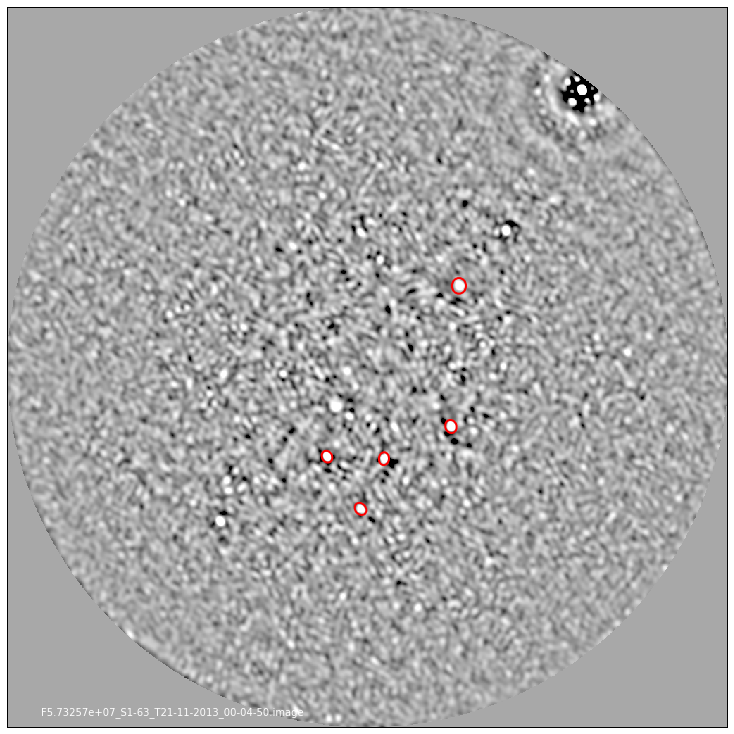

In [11]:
combined = zip(images, fitss, sourcess)
for index, (image, fits, sources) in enumerate(combined):
    fig = pyplot.figure(figsize=(image_size, image_size))
    plot = FITSFigure(fits, subplot=[0, 0, 1, 1], figure=fig)
    
    # so here you can tweak the scale if you want, maybe change contrast or color schema
    #
    # http://aplpy.readthedocs.org/en/stable/normalize.html
    #
    plot.show_grayscale(stretch='sqrt')
    #plot.show_colorscale(stretch='sqrt')
    
    # you probably don't want to change this
    plot.axis_labels.hide()
    plot.tick_labels.hide()
    plot.ticks.hide()
    ra = [source.ra for source in sources]
    dec = [source.decl for source in sources]
    semimajor = [source.semimajor / 900 for source in sources]
    semiminor = [source.semiminor / 900 for source in sources]
    pa = [source.pa + 90 for source in sources]

    # this adds the extracted sources, you can configure the colors with the settings above
    color = [source_colors[source.extract_type] for source in sources]
    plot.show_ellipses(ra, dec, semimajor, semiminor, pa, facecolor='none',
                       edgecolor=color, linewidth=2)
    
    # you can change the bottom text here
    plot.add_label(.23, .02, image.url.split('/')[-1], relative=True, color='white')
    plot.save(os.path.join(output_folder, str(index) + '.png'))